# Generate RAVEN dataset for diffusion 

In [1]:
import os
from os.path import join
import random
from tqdm import tqdm, trange
import numpy as np 
import torch 
import torchvision
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## Image Dataset: 3 rows

In [5]:
# pos_list = [[20,20], [20,60], [20,100], 
#             [60,20], [60,60], [60,100], 
#             [100,20], [100,60], [100,100]]
offset = 0
pos_list = [[x + offset, y + offset] for x in [0, 40, 80] for y in [0, 40, 80]]
d_PGM = torch.load('PGM_shape_size_color_normalized.pt') # torch.Size([7, 10, 10, 40, 40])

def load_PGM_inputs(attr): 
    """attr: (3, 9, 3), (num_panel, num_pos, num_attr)"""
    inputs = -0.6891*torch.ones((3, 120 + 2*offset, 120 + 2*offset))
    for i_panel in range(3): 
        for i_pos in range(9): 
            if attr[i_panel, i_pos, 0] != -1: 
                i_shape, i_size, i_color = attr[i_panel, i_pos]
                x0, y0 = pos_list[i_pos]
                inputs[i_panel, x0:(x0+40), y0:(y0+40)] = d_PGM[int(i_shape), int(i_size), int(i_color)]
    return inputs 

class dataset_PGM_single(Dataset): 
    def __init__(self, attr_list): 
        """attr_list: [num_samples, 3, 9, 3]"""
        self.attr_list = attr_list  
        
    def __len__(self): 
        return len(self.attr_list)
    
    def __getitem__(self, idx): 
        """attr: [3, 9, 3]"""
        attr = self.attr_list[idx] 
        inputs = load_PGM_inputs(attr)
        return inputs, idx

In [89]:
train_inputs = torch.load('train_inputs.pt') # [35, 10000, 3, 9, 3]
print(train_inputs.shape)

torch.Size([35, 10000, 3, 9, 3])


In [90]:
# example: 
i_class = 4
dataset_class0 = dataset_PGM_single(train_inputs[i_class]) 
load_class0 = DataLoader(dataset_class0, batch_size=256, shuffle=False, pin_memory=True) 

In [108]:
!echo $WORK_DIR

/n/holylabs/LABS/kempner_fellows/Users/binxuwang


In [107]:
%ls $WORK_DIR/Datasets

2020-BigGAN/         cifar10.zip         Imagenet64_val.zip    Mat_Statistics/
2020-BigGAN.zip      ffhq-64x64.zip      imagenet-valid/       Stimuli/
2021-EvolDecomp.zip  GAN_sample_fid.zip  img_align_celeba.zip  stl10_binary/


In [111]:
!pwd

/n/home12/binxuwang/Github/DiffusionReasoning


In [124]:

rootdir = r"/n/home12/binxuwang/Datasets/RAVEN_Datasets/PGM"
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


# Fix random seed for generator
for i_class in range(train_inputs.shape[0]):
    if i_class == 10:
        break
    os.makedirs(join(rootdir,f'rule{i_class}'), exist_ok=True)
    rule_dir = join(rootdir,f'rule{i_class}')
    dataset_class0 = dataset_PGM_single(train_inputs[i_class]) 
    set_seed(42)
    load_class0 = DataLoader(dataset_class0, batch_size=3, shuffle=True, pin_memory=True, drop_last=True) 
    for i_batch, (inputs, row_ids) in tqdm(enumerate(load_class0)):
        # print(inputs.shape)
        # print(row_ids)
        inputs = 1 - inputs / (-0.6891)
        mtg = make_grid(inputs.reshape(-1, 1, 120 + 2*offset, 120 + 2*offset), nrow=3, padding=1, pad_value=1)
        mtg_rsz = torchvision.transforms.functional.resize(mtg, (256, 256))
        save_image(mtg, join(rule_dir, f'mtg_{row_ids[0]}_{row_ids[1]}_{row_ids[2]}.png'), )
        # plt.imshow(mtg_rsz.permute(1, 2, 0))
        # plt.axis('off')
        # plt.show()
        # raise Exception
    print(f'rule {i_class} done')

3333it [01:08, 48.88it/s]


rule 0 done


3333it [01:01, 54.28it/s]


rule 1 done


3333it [01:01, 54.26it/s]


rule 2 done


3333it [01:01, 54.13it/s]


rule 3 done


3333it [01:01, 54.20it/s]


rule 4 done


3333it [01:03, 52.79it/s]


rule 5 done


3333it [01:03, 52.77it/s]


rule 6 done


3333it [01:02, 53.00it/s]


rule 7 done


3333it [01:00, 55.15it/s]


rule 8 done


3333it [01:01, 54.58it/s]

rule 9 done


NameError: name 'Dataset' is not defined

In [120]:
mtg.shape

torch.Size([3, 122, 364])

In [91]:
inputs = next(iter(load_class0))
print(inputs.shape)

torch.Size([256, 3, 120, 120])


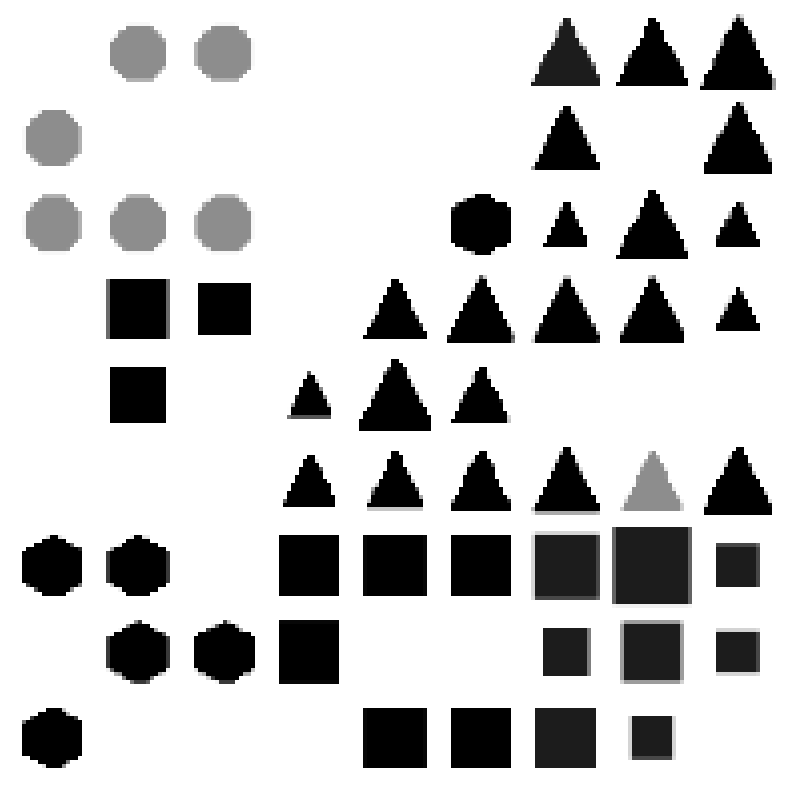

In [93]:
import torchvision
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt
mtg1 = make_grid(inputs[2,][:,None] / -0.6891, nrow=3, padding=0, pad_value=1)
mtg2 = make_grid(inputs[4,][:,None] / -0.6891, nrow=3, padding=0, pad_value=1)
mtg3 = make_grid(inputs[10,][:,None] / -0.6891, nrow=3, padding=0, pad_value=1)
plt.figure(figsize=(10,10))
plt.imshow(torchvision.transforms.Resize((192, 192))(
           torch.cat([mtg1, mtg2, mtg3], dim=1),).permute(1,2,0))
plt.axis('off')
plt.show()


## Abstract Attribute Dataset

In [ ]:
print(train_inputs[i_class][:,:,:,0].to(int).unique())
print(train_inputs[i_class][:,:,:,1].to(int).unique())
print(train_inputs[i_class][:,:,:,2].to(int).unique())

tensor([-1,  0,  1,  2,  3,  4,  5,  6])
tensor([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9])
tensor([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9])


In [ ]:

def load_PGM_abstract(attr): 
    """attr: (3, 9, 3), (num_panel, num_pos, num_attr)"""
    attr = attr.to(int)
    attr = torch.cat(tuple(attr.view(3, 3, 3, 3)), dim=1) # [3, 3, 3, 3] -> [3, 9, 3]
    inputs = attr.permute(2, 0, 1) # num_attr, num_row=3, num_col (n panel x 3)
    return inputs 

class dataset_PGM_abstract_single(Dataset): 
    def __init__(self, attr_list): 
        """attr_list: [num_samples, 3, 9, 3]"""
        self.attr_list = attr_list  
        
    def __len__(self): 
        return len(self.attr_list)
    
    def __getitem__(self, idx): 
        """attr: [3, 9, 3]"""
        attr = self.attr_list[idx] 
        inputs = load_PGM_abstract(attr)
        return inputs

In [11]:
import einops
train_attrs = torch.load('/n/home12/binxuwang/Github/DiffusionReasoning/train_inputs.pt') # [35, 10000, 3, 9, 3]
n_classes = train_attrs.shape[0]
n_samples = train_attrs.shape[1]
labels = torch.arange(0, n_classes).unsqueeze(1).expand(n_classes, n_samples)
train_attrs = train_attrs.to(int)
train_row_img = einops.rearrange(train_attrs, 'c s pnl (H W) att -> c s att H (pnl W)', H=3, W=3, att=3, pnl=3)

In [ ]:
# import torch
# from torch.utils.data import Dataset, DataLoader
import itertools
# Create an infinite iterator from the dataloader

dataloader = DataLoader(range(10), batch_size=3, shuffle=True, drop_last=True)
# dataloader_cycle = itertools.cycle(dataloader)
# Iterate over the dataloader
tuples = []
for batch in dataloader:
    print(batch)
    tuples.append(batch)
    # raise Exception

In [46]:
cmb_per_class = 10000
X = []
y = []
row_ids = []
for iclass in trange(n_classes):
    tuple_loader = DataLoader(range(n_samples), batch_size=3, shuffle=True, drop_last=True)
    X_class = []
    row_ids_cls = []
    while True:
        try:
            batch = next(iter(tuple_loader))
            row_ids_cls.append(batch)
            if len(row_ids_cls) == cmb_per_class:
                break
        except StopIteration:
            tuple_loader = DataLoader(range(n_samples), batch_size=3, shuffle=True, drop_last=True)
    raise Exception
    y_class = torch.tensor([iclass]*len(X_class), dtype=torch.int)
    X_class = torch.stack(X_class)
    row_ids_cls = torch.stack(row_ids_cls)
    y.append(y_class)
    X.append(X_class)
    row_ids.append(row_ids_cls)
X = torch.cat(X, dim=0)
y = torch.cat(y, dim=0)
row_ids = torch.cat(row_ids, dim=0)

  0%|                                                                                                            | 0/35 [00:02<?, ?it/s]


Exception: 

In [50]:
torch.stack(row_ids_cls)

tensor([[7863, 1287, 1122],
        [9583,  201, 7632],
        [9221, 3243, 9831],
        ...,
        [6937, 6762, 1933],
        [5194, 1758, 6915],
        [3969, 2907, 8533]])

In [139]:
def _sample_panels(train_row_img, cmb_per_class=3333):
    n_classes = train_row_img.shape[0]
    n_samples = train_row_img.shape[1]
    X = []
    y = []
    row_ids = []
    for iclass in trange(n_classes):
        tuple_loader = DataLoader(range(n_samples), batch_size=3, shuffle=True, drop_last=True)
        X_class = []
        row_ids_cls = []
        while True:
            try:
                batch = next(iter(tuple_loader))
                rows = train_row_img[iclass][batch]
                mtg = torch.cat(tuple(rows), dim=1)
                X_class.append(mtg)
                row_ids_cls.append(batch)
                if len(X_class) == cmb_per_class:
                    break
            except StopIteration:
                tuple_loader = DataLoader(range(n_samples), batch_size=3, shuffle=True, drop_last=True)

        y_class = torch.tensor([iclass]*len(X_class), dtype=torch.int)
        X_class = torch.stack(X_class)
        row_ids_cls = torch.stack(row_ids_cls)
        y.append(y_class)
        X.append(X_class)
        row_ids.append(row_ids_cls)
    X = torch.cat(X, dim=0)
    y = torch.cat(y, dim=0)
    row_ids = torch.cat(row_ids, dim=0)
    return X, y, row_ids


class dataset_PGM_abstract(Dataset): 
    def __init__(self, cmb_per_class=3333, train_attrs=None, device="cpu", onehot=False): 
        """attr_list: [num_samples, 3, 9, 3]"""
        if train_attrs is None:
            train_attrs = torch.load('/n/home12/binxuwang/Github/DiffusionReasoning/train_inputs.pt') # [35, 10000, 3, 9, 3]
        n_classes = train_attrs.shape[0] # 35
        n_samples = train_attrs.shape[1] # 10k
        self.labels = torch.arange(0, n_classes).unsqueeze(1).expand(n_classes, n_samples)
        train_attrs = train_attrs.to(int)
        self.train_row_img = einops.rearrange(train_attrs, 'c s pnl (H W) attr -> c s attr H (pnl W)', H=3, W=3, attr=3, pnl=3)
        self.X, self.y, self.row_ids = _sample_panels(self.train_row_img, cmb_per_class)
        self.X = self.X.to(device) # [35 * cmb_per_class, 3, 9, 9]
        if onehot is True:
            O1 = torch.eye(7, 7, dtype=int)
            O2 = torch.eye(10, 10, dtype=int)
            O3 = torch.eye(10, 10, dtype=int)
            X_onehot = torch.cat([O1[self.X[:, 0], :], O2[self.X[:, 1], :], O3[self.X[:, 2], :], ], dim=-1)
            print(X_onehot.shape)
            self.X = einops.rearrange(X_onehot, 'b h w C -> b C h w')
            print(self.X.shape)
            self.Xmean = torch.tensor([0.5, ]).view(1, 1, 1, 1)
            self.Xstd = torch.tensor([0.5, ]).view(1, 1, 1, 1)
            self.X = (self.X.float() - self.Xmean) / self.Xstd
        else:
            self.Xmean = torch.tensor([1.5, 2.5, 2.5]).view(1, 3, 1, 1).to(device)
            self.Xstd = torch.tensor([2.5, 3.5, 3.5]).view(1, 3, 1, 1).to(device)
            self.X = (self.X - self.Xmean) / self.Xstd
        
    def __len__(self): 
        return len(self.y)
    
    def __getitem__(self, idx): 
        """attr: [3, 9, 3]"""
        return self.X[idx], self.y[idx]
    
    def dict(self):
        return {'row_ids': self.row_ids, 'y': self.y}
    

In [140]:
dataset = dataset_PGM_abstract(cmb_per_class=3333, )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:35<00:00,  1.02s/it]


In [141]:
dataset = dataset_PGM_abstract(cmb_per_class=10, onehot=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 312.33it/s]

torch.Size([350, 9, 9, 27])
torch.Size([350, 27, 9, 9])


In [ ]:
dataset

In [53]:
print(dataset.X.float().mean(dim=(0,2,3)))
print(dataset.X.float().std(dim=(0,2,3)))

tensor([1.4295, 2.3996, 2.4022])
tensor([2.4291, 3.4340, 3.4326])


In [ ]:
dataset = dataset_PGM_abstract(cmb_per_class=3333)

In [33]:
dataset.row_ids.shape

torch.Size([350000, 3])

In [40]:
dataset[0][0]

tensor(9)

In [6]:
train_attrs.shape # [35, 10000, 3, 9, 3] 

torch.Size([35, 10000, 3, 9, 3])

In [12]:
einops.rearrange(train_attrs, 'c s pnl (H W) att -> c s att H (pnl W)', H=3, W=3).shape

torch.Size([35, 10000, 3, 3, 9])

In [15]:
train_row_img.shape

torch.Size([35, 10000, 3, 3, 9])

In [132]:

train_attrs = train_attrs.view(n_classes * n_samples, 3, 9, 3) # 3 panels, 9 positions, 3 attributes
train_attrs.permute(0, 3, 1, 2).shape
train_attrs = train_attrs.view(n_classes * n_samples, 3, 3, 3, 3) # [n_classes * n_samples, 9, 3, 3]

In [137]:
%load_ext autoreload
%autoreload 2

In [138]:
import einops

ModuleNotFoundError: No module named 'einops'

In [ ]:
dataset_abstr = dataset_PGM_abstract_single(train_inputs[i_class])

In [ ]:
print(dataset_abstr[1].shape)
dataset_abstr[1]

torch.Size([3, 3, 9])


tensor([[[-1,  4,  4,  1,  1,  1, -1,  3, -1],
         [ 4,  4,  4,  1,  1,  1, -1, -1, -1],
         [-1, -1,  4,  1,  1,  1, -1, -1,  3]],

        [[-1,  6,  5,  5,  6,  2, -1,  7, -1],
         [ 5,  3,  2,  0,  5,  0, -1, -1, -1],
         [-1, -1,  0,  3,  7,  4, -1, -1,  5]],

        [[-1,  0,  0,  2,  2,  2, -1,  4, -1],
         [ 0,  0,  0,  2,  2,  2, -1, -1, -1],
         [-1, -1,  0,  2,  2,  2, -1, -1,  7]]])

### New rule samples

In [2]:
data_dir = '/n/home12/binxuwang/Github/DiffusionReasoning/'

attr_all = np.load(data_dir+'attr_all.npy')

In [6]:
i_class = 37
dataset_class0 = dataset_PGM_single(attr_all[i_class]) 

In [11]:
dataset_class0[1][0]

torch.Size([3, 120, 120])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


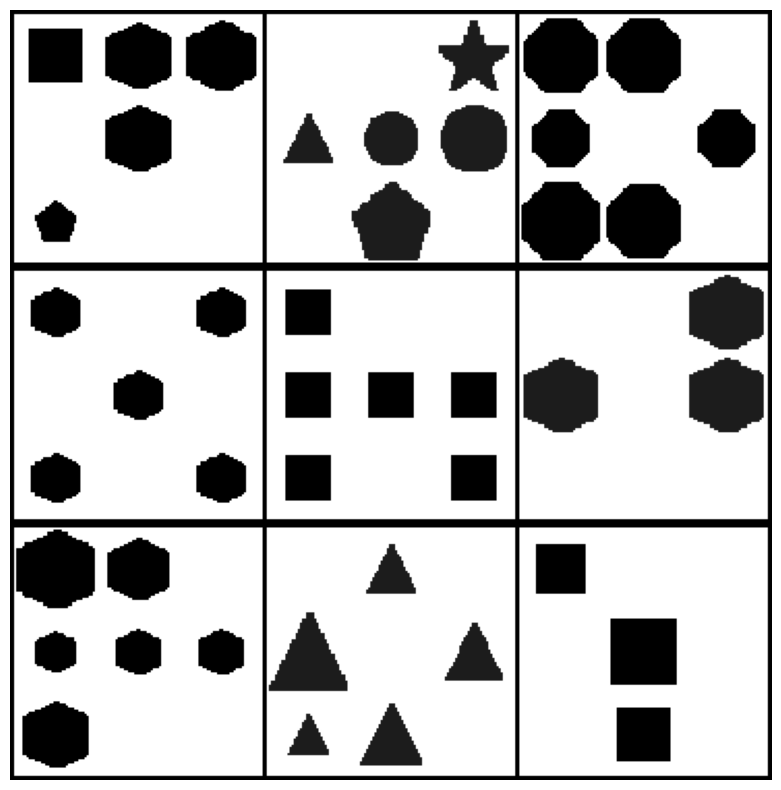

In [16]:
import torchvision
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt
i_class = 37
idx = (0,3,5)
dataset_class0 = dataset_PGM_single(attr_all[i_class]) 
mtg1 = make_grid(dataset_class0[idx[0]][0][:,None] / -0.6891, nrow=3, padding=2, pad_value=0)
mtg2 = make_grid(dataset_class0[idx[1]][0][:,None] / -0.6891, nrow=3, padding=2, pad_value=0)
mtg3 = make_grid(dataset_class0[idx[2]][0][:,None] / -0.6891, nrow=3, padding=2, pad_value=0)
plt.figure(figsize=(10,10))
plt.imshow(torch.cat([mtg1, mtg2, mtg3], dim=1).permute(1,2,0))
# plt.imshow(torchvision.transforms.Resize((192, 192))(
#            torch.cat([mtg1, mtg2, mtg3], dim=1),).permute(1,2,0))
plt.axis('off')
plt.show()